# 구글 드라이브 마운트 및 필요한 라이브러리 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/')
print('변경된 작업 경로 : ',os.getcwd())

변경된 작업 경로 :  /content/drive/.shortcut-targets-by-id/1arhzGkzN9BhNomv5vjsVxKQRfM6lOeEG/CT-MRI_2way_converter/cycleGAN


In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-addons
!pip install --upgrade tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import os

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 데이터 셋 업로드 및 전처리(사이즈 조정, 파일명을 1부터 순차적으로 변경)

학습에 필요한 데이터셋(CT 및 MRI이미지 / Train:Test=6:3)이 있는 GOOGLE DRIVE가 마운트되어 있으므로

따로 데이터 셋을 업로드 할 필요 없었음.

In [ ]:
from google.colab import drive
import os
from PIL import Image
import os

# Train , Val, Test 데이터 셋에 전처리

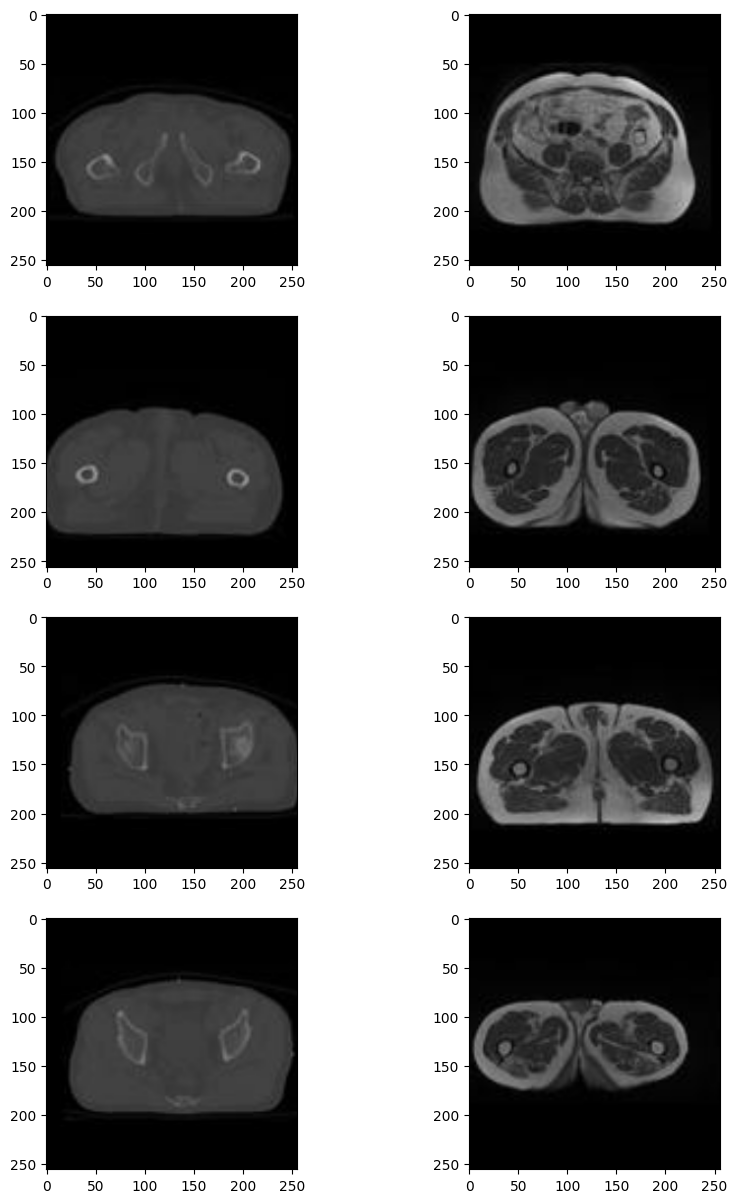

In [ ]:
tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

# Load the CT-MRI dataset using tensorflow-datasets.

train_CT_dir = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TRAIN_CT"
train_MRI_dir = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TRAIN_MRI"
test_CT_dir = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TEST_CT"
test_MRI_dir = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TEST_MRI"

buffer_size = 256
batch_size = 1
height=256
width=256

# Load the CT and MRI datasets using TensorFlow Datasets
train_CT = tf.data.Dataset.list_files(train_CT_dir + '/*.jpg')
train_MRI = tf.data.Dataset.list_files(train_MRI_dir + '/*.jpg')
test_CT = tf.data.Dataset.list_files(test_CT_dir + '/*.jpg')
test_MRI = tf.data.Dataset.list_files(test_MRI_dir + '/*.jpg')

# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [*orig_img_size])
    img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img


def preprocess_test_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

"""def preprocess_train_image(img,label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img,label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img"""

def extract_filename(file_path):
    # Use regular expression to extract the filename without extension
    return tf.strings.regex_replace(tf.strings.regex_replace(file_path, ".*/", ""), ".jpg", "")

"""## Create `Dataset` objects"""
# Apply the preprocessing operations to the training data
train_CT = (
    train_CT.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .batch(batch_size)
)
train_MRI = (
    train_MRI.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_CT = (
    test_CT.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .batch(batch_size)
)
test_MRI = (
    test_MRI.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .batch(batch_size)
)

"""## Visualize some samples"""

_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_CT.take(4), train_MRI.take(4))):
    A = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    B = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(A)
    ax[i, 1].imshow(B)
plt.savefig('./image.png')

#생성자와 판별자 작성에 필요한 BUILDING BLOCK

In [ ]:
"""## Building blocks used in the CycleGAN generators and discriminators"""

class ReflectionPadding2D(layers.Layer):

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

"""## Build the generators"""

def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model




# 판별자 코드

In [ ]:
"""## Build the discriminators"""

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


#Cyclegan 모델 코드

In [ ]:
"""## Build the CycleGAN model

We will override the `train_step()` method of the `Model` class
for training via `fit()`.
"""

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is A and y is B
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adversarial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # A to fake B
            fake_y = self.gen_G(real_x, training=True)
            # B to fake A -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (A to fake B to fake A): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (B to fake A to fake B) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

"""## Create a callback that periodically saves generated images"""

class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(test_CT.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.utils.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()



# **TRAIN** [ CT to MRI ]
CT to MRI, MRI to CT 두 단방향 모델 중 'CT to MRI image translation'하는 모델 훈련

MRI 420
CT 420
Epoch 1/5
420/420 [==============================] - ETA: 0s - G_loss: 2.2388 - F_loss: 1.6319 - D_X_loss: 0.2422 - D_Y_loss: 0.2236

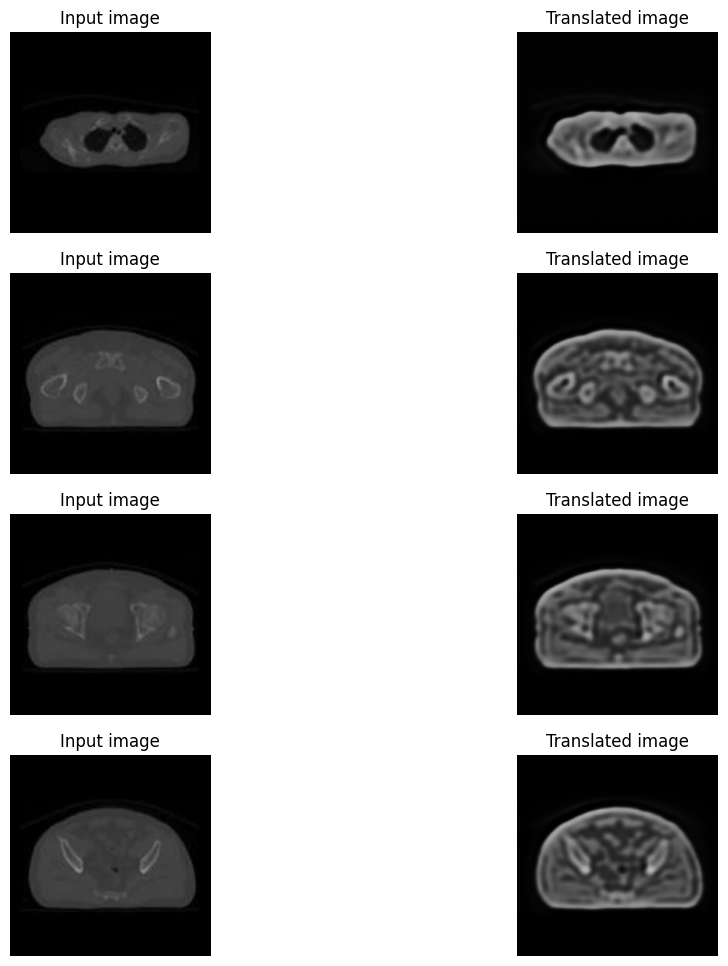

420/420 [==============================] - 384s 700ms/step - G_loss: 2.2361 - F_loss: 1.6292 - D_X_loss: 0.2421 - D_Y_loss: 0.2236
Epoch 2/5
420/420 [==============================] - ETA: 0s - G_loss: 0.9686 - F_loss: 0.4956 - D_X_loss: 0.2483 - D_Y_loss: 0.2340

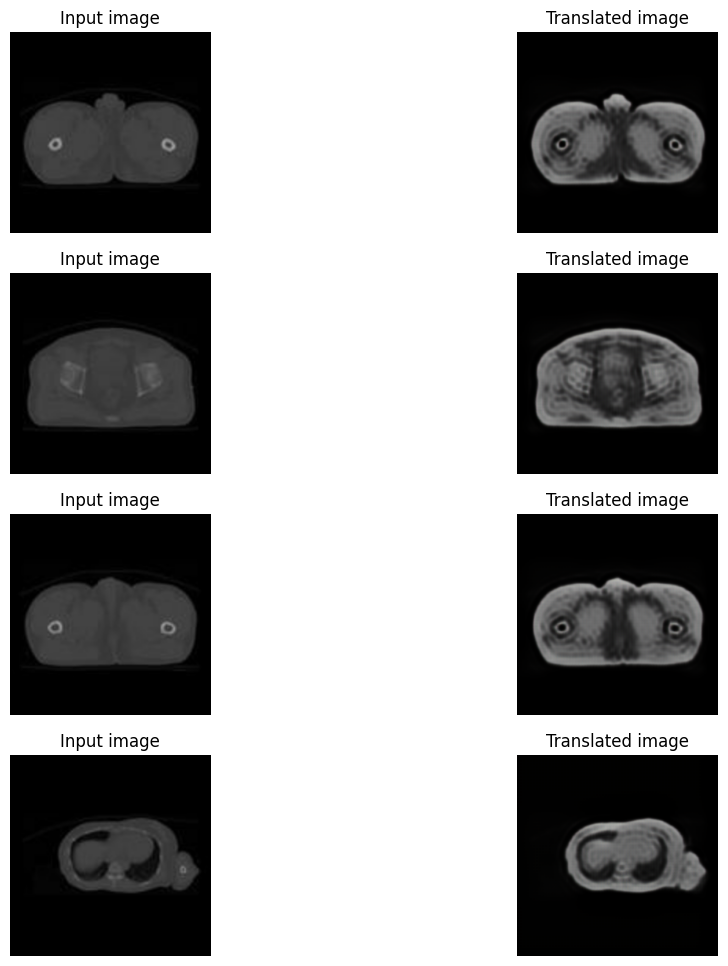

420/420 [==============================] - 299s 711ms/step - G_loss: 0.9688 - F_loss: 0.4954 - D_X_loss: 0.2483 - D_Y_loss: 0.2340
Epoch 3/5
420/420 [==============================] - ETA: 0s - G_loss: 0.9305 - F_loss: 0.4432 - D_X_loss: 0.2489 - D_Y_loss: 0.2296

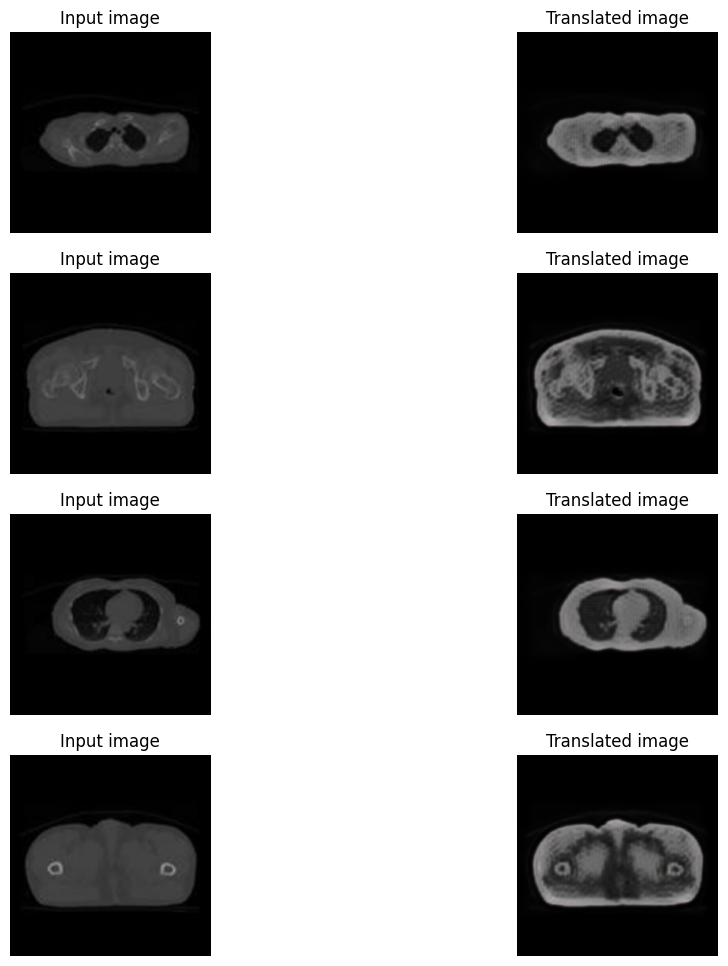

420/420 [==============================] - 307s 731ms/step - G_loss: 0.9307 - F_loss: 0.4431 - D_X_loss: 0.2489 - D_Y_loss: 0.2296
Epoch 4/5
420/420 [==============================] - ETA: 0s - G_loss: 0.8708 - F_loss: 0.4171 - D_X_loss: 0.2487 - D_Y_loss: 0.2322

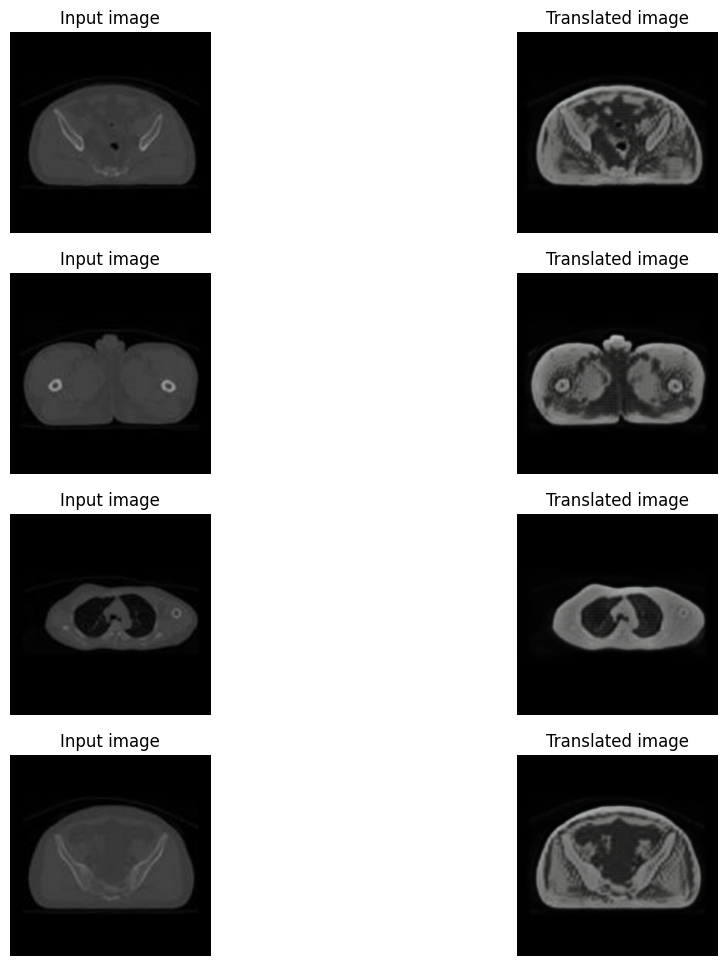

420/420 [==============================] - 302s 719ms/step - G_loss: 0.8707 - F_loss: 0.4170 - D_X_loss: 0.2487 - D_Y_loss: 0.2323
Epoch 5/5
420/420 [==============================] - ETA: 0s - G_loss: 0.8471 - F_loss: 0.4084 - D_X_loss: 0.2482 - D_Y_loss: 0.2332

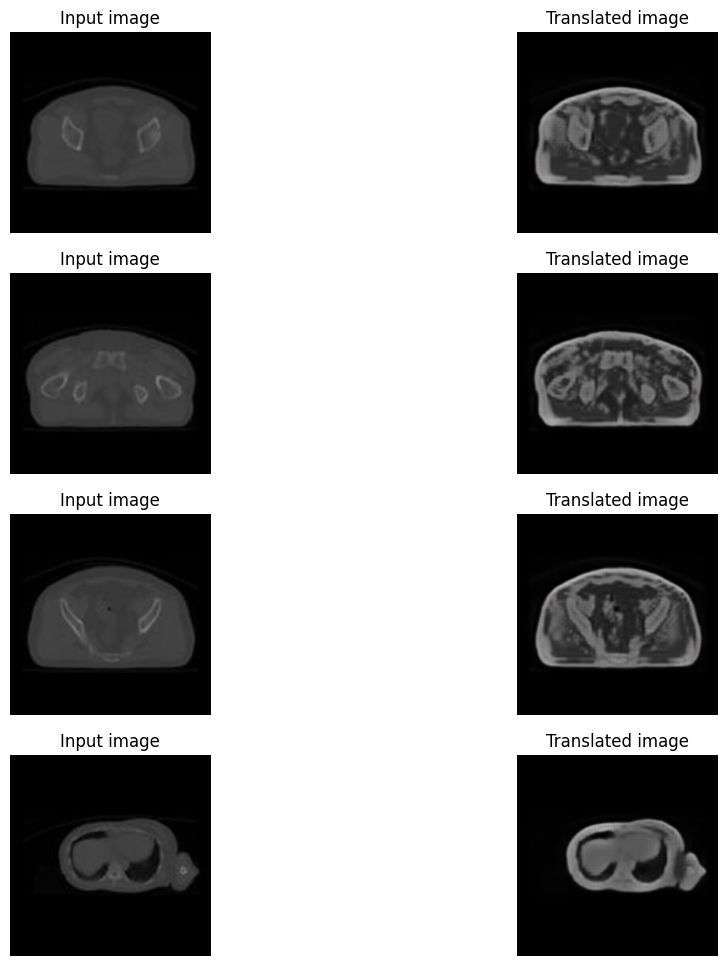

420/420 [==============================] - 306s 728ms/step - G_loss: 0.8470 - F_loss: 0.4083 - D_X_loss: 0.2483 - D_Y_loss: 0.2333


In [ ]:
"""## Train the end-to-end model"""

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/cyclegan_ct2mri_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True
)

print('MRI',len(train_MRI))
print('CT',len(train_CT))


# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_CT, train_MRI)),
    epochs=5,
    callbacks=[plotter, model_checkpoint_callback],
)


# **TEST** [CT to MRI]

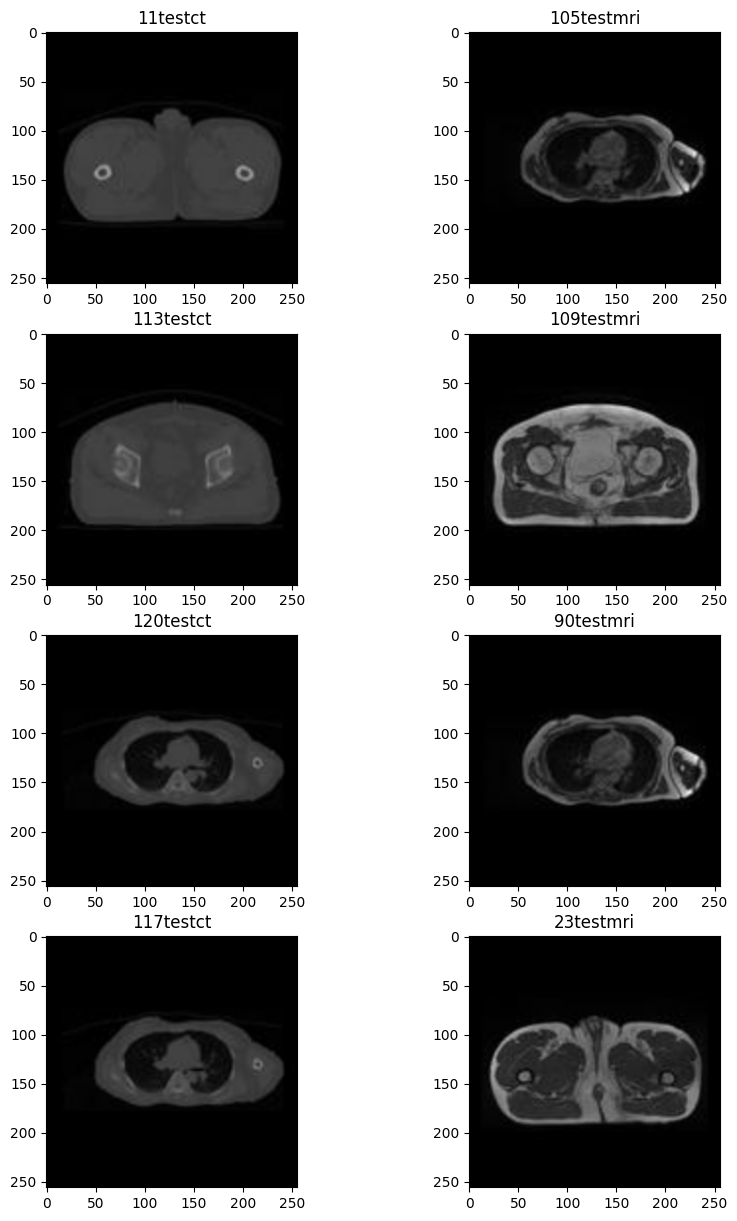

In [ ]:
#TEST 이름 식별위한 전처리

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

# Load the CT-MRI dataset using tensorflow-datasets.
test_CT_dir = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TEST_CT"
test_MRI_dir = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TEST_MRI"

buffer_size = 256
batch_size = 1
height = 256
width = 256

# Load the CT and MRI datasets using TensorFlow Datasets
test_CT = tf.data.Dataset.list_files(test_CT_dir + '/*.jpg')
test_MRI = tf.data.Dataset.list_files(test_MRI_dir + '/*.jpg')

# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_train_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [*orig_img_size])
    img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img

def preprocess_test_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

# Extracting filename function
def extract_filename(file_path):
    file_name = tf.strings.regex_replace(tf.strings.regex_replace(file_path, "/", "_"), ".jpg", "")
    return tf.strings.split(file_name, "_")[-1]

# Apply the preprocessing operations to the training data
test_CT = test_CT.map(lambda x: (preprocess_test_image(x), extract_filename(x)))
test_MRI = test_MRI.map(lambda x: (preprocess_test_image(x), extract_filename(x)))

# Visualize some samples
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(test_CT.take(4), test_MRI.take(4))):
    A, name_A = samples[0][0], samples[0][1]
    B, name_B = samples[1][0], samples[1][1]

    A = (((A * 127.5) + 127.5).numpy()).astype(np.uint8)
    B = (((B * 127.5) + 127.5).numpy()).astype(np.uint8)

    ax[i, 0].imshow(A)
    ax[i, 0].set_title(name_A.numpy().decode('utf-8'))  # Display the file name
    ax[i, 1].imshow(B)
    ax[i, 1].set_title(name_B.numpy().decode('utf-8'))  # Display the file name

plt.savefig('./image.png')


TEST [CT2MRI]

In [ ]:
from pathlib import Path
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# 특정 경로에 예측 결과 이미지를 저장할 디렉토리를 지정합니다.
output_directory = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/cycleGAN_ct2mri_result"

# 체크포인트 로드
weight_file = "/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/cyclegan_ct2mri_checkpoints.005"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

_, ax = plt.subplots(210, 2, figsize=(15, 3 * 210))
for i, (img, file_path) in enumerate(test_CT):
    # 파일 이름 추출
    original_file_name = Path(file_path.numpy().decode('utf-8')).stem
    print(f"Original File Name: {original_file_name}")

    # 모델이 예상하는 형태로 입력 이미지의 차원을 변경
    img = tf.expand_dims(img, axis=0)

    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title(f"Input image (CT)\n{original_file_name}")
    ax[i, 1].set_title(f"Translated image(fake MRI)\n{original_file_name}")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # 예측 결과 이미지 저장
    prediction = keras.utils.array_to_img(prediction)
    prediction = prediction.resize((256, 256))  # Choose new_width and new_height accordingly
    prediction_image_name = f"{original_file_name}_predicted.png"
    print(f"Predicted Image Name: {prediction_image_name}")
    prediction.save(Path(output_directory) / prediction_image_name)

plt.tight_layout()
plt.savefig('./prediction.png')




Weights loaded successfully
Original File Name: 46testct
Predicted Image Name: 46testct_predicted.png
Original File Name: 138testct
Predicted Image Name: 138testct_predicted.png
Original File Name: 148testct
Predicted Image Name: 148testct_predicted.png
Original File Name: 6testct
Predicted Image Name: 6testct_predicted.png
Original File Name: 40testct
Predicted Image Name: 40testct_predicted.png
Original File Name: 177testct
Predicted Image Name: 177testct_predicted.png
Original File Name: 69testct
Predicted Image Name: 69testct_predicted.png
Original File Name: 199testct
Predicted Image Name: 199testct_predicted.png
Original File Name: 188testct
Predicted Image Name: 188testct_predicted.png
Original File Name: 159testct
Predicted Image Name: 159testct_predicted.png
Original File Name: 142testct
Predicted Image Name: 142testct_predicted.png
Original File Name: 86testct
Predicted Image Name: 86testct_predicted.png
Original File Name: 179testct
Predicted Image Name: 179testct_predicted.

#**성능평가(PSNR, SSIM)** [CT to MRI]

In [ ]:
import cv2
from skimage.metrics import structural_similarity

def calculate_psnr_and_ssim(img1_path, img2_path):
    # 이미지 파일을 그레이스케일로 로드
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # 이미지 크기를 동일하게 조정
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

    # PSNR 계산
    psnr = cv2.PSNR(img1, img2)

    # SSIM 계산
    ssim = structural_similarity(img1, img2, multichannel=False)

    return psnr, ssim

# 이미지 파일 경로
img1_path = '/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/DATA1/TEST_MRI/5testmri.jpg'
img2_path = '/content/drive/MyDrive/CT-MRI_2way_converter/cycleGAN/cycleGAN_ct2mri_result/5testct_predicted.png'

# PSNR과 SSIM 계산
psnr_value, ssim_value = calculate_psnr_and_ssim(img1_path, img2_path)

# 결과 출력
print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")


PSNR: 17.123608809693923
SSIM: 0.6250941389276475


<ipython-input-22-c3671f701ae5>:16: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(img1, img2, multichannel=False)
